In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
traindata = pd.read_csv('archive/interactions_train.csv')
traindata.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [3]:
##baseline
allRatings = []
userRatings = defaultdict(list)
recipeRatings = defaultdict(list)
for i in range(len(traindata)):
    allRatings.append(traindata['rating'][i])
    userRatings[traindata['user_id'][i]].append(traindata['rating'][i])
    recipeRatings[traindata['recipe_id'][i]].append(traindata['rating'][i])

globalAverage = sum(allRatings) / len(allRatings)
## user average
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

## recipe average
recipeAverage = {}
for r in recipeRatings:
  recipeAverage[r] = sum(recipeRatings[r]) / len(recipeRatings[r])

/var/folders/dc/3r50xk6s1md2fzzsshnrjt140000gn/T/ipykernel_66725/975119632.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(allRatings, hist=False, rug=True, label='all ratings')
/var/folders/dc/3r50xk6s1md2fzzsshnrjt140000gn/T/ipykernel_66725/975119632.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

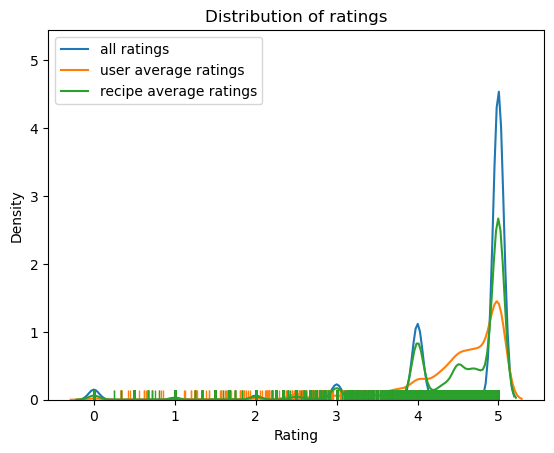

In [4]:
# plotting distribtuions of ratings in same plot for comparison with title
sns.distplot(allRatings, hist=False, rug=True, label='all ratings')
sns.distplot(list(userAverage.values()), hist=False, rug=True, label='user average ratings')
sns.distplot(list(recipeAverage.values()), hist=False, rug=True, label='recipe average ratings')
plt.legend()
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

In [5]:
## Applying baseline to test data
testdata = pd.read_csv('archive/interactions_test.csv')
testdata.head()

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


In [6]:
baselineType = {'user': 0, 'recipe': 0, 'global': 0, 'hybrid': 0}
predictions = []
for i in range(len(testdata)):
    user = testdata['user_id'][i]
    recipe = testdata['recipe_id'][i]
    if user in userAverage and recipe in recipeAverage:
        predictions.append((userAverage[user] + recipeAverage[recipe]) / 2)
        baselineType['hybrid'] += 1
    elif user in userAverage:
        predictions.append(userAverage[user])
        baselineType['user'] += 1
    elif recipe in recipeAverage:
        predictions.append(recipeAverage[recipe])
        baselineType['recipe'] += 1
    else:
        predictions.append(globalAverage)
        baselineType['global'] += 1

testdata['prediction'] = predictions
testdata.head()

,user_id,recipe_id,date,rating,u,i,prediction
0,8937,44551,2005-12-23,4.0,2,173538,4.222222
1,56680,126118,2006-10-07,4.0,16,177847,4.833333
2,349752,219596,2008-04-12,0.0,26,89896,5.000000
3,628951,82783,2007-11-13,2.0,45,172637,5.000000
4,92816,435013,2013-07-31,3.0,52,177935,4.566964


In [7]:
baselineType

{'user': 12455, 'recipe': 0, 'global': 0, 'hybrid': 0}

In [8]:
## Calculating metrics (accuracy, TP, FP, TN, FN, precision, recall, F1, MSE, MAE)
def metrics(pred, label):
    TP = [a and b for (a,b) in zip(predictions,label)]
    TN = [not a and not b for (a,b) in zip(predictions,label)]
    FP = [a and not b for (a,b) in zip(predictions,label)]
    FN = [not a and b for (a,b) in zip(predictions,label)]

    TP = sum(TP)
    TN = sum(TN)
    FP = sum(FP)
    FN = sum(FN)
    BER = 0.5 * (FP / (TN + FP) + FN / (FN + TP))
    accuracy = (TP +TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * (precision * recall) / (precision + recall)
    MSE = sum([(a - b) ** 2 for (a,b) in zip(predictions,label)]) / len(predictions)
    MAE = sum([abs(a - b) for (a,b) in zip(predictions,label)]) / len(predictions)

    outDict = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'BER': BER, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'F1': F1, 'MSE': MSE, 'MAE': MAE}
    return outDict



In [18]:
GeneralMetrics = metrics(predictions, list(testdata['rating']))
GeneralMetrics

{'TP': 52380.0,
 'TN': 34,
 'FP': 653.0,
 'FN': 94.0,
 'BER': 0.4761504123841687,
 'accuracy': 0.9859483455916932,
 'precision': 0.987686911922765,
 'recall': 0.9982086366581545,
 'F1': 0.9929199010492195,
 'MSE': 1.8334151093136715,
 'MAE': 0.8285410843529394}

In [19]:
### Round predictions to avoid non-integer ratings
predictions_round = [round(x) for x in predictions]
RoundMetrics = metrics(predictions_round,list(testdata['rating']))
RoundMetrics

[4.222222222222222, 4.833333333333333, 5.0, 5.0, 4.566964285714286, 4.653960690887433, 3.945945945945946, 4.9, 4.834410740924913, 4.710120068610634]
[4, 5, 5, 5, 5, 5, 4, 5, 5, 5]
0    4.0
1    4.0
2    0.0
3    2.0
4    3.0
5    5.0
6    0.0
7    5.0
8    0.0
9    5.0
Name: rating, dtype: float64


{'TP': 52380.0,
 'TN': 34,
 'FP': 653.0,
 'FN': 94.0,
 'BER': 0.4761504123841687,
 'accuracy': 0.9859483455916932,
 'precision': 0.987686911922765,
 'recall': 0.9982086366581545,
 'F1': 0.9929199010492195,
 'MSE': 1.8334151093136715,
 'MAE': 0.8285410843529394}